# Chapter 15 - Gradient Boosting with XGBoost and LigthGBM

## Listing 15-1. Importing the data

In [4]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
metro_interstate_traffic_volume = fetch_ucirepo(id=492) 
  
# data (as pandas dataframes) 
X = metro_interstate_traffic_volume.data.features 
y = metro_interstate_traffic_volume.data.targets 
  
# metadata 
print(metro_interstate_traffic_volume.metadata) 
  
# variable information 
print(metro_interstate_traffic_volume.variables) 

# Merge the features and target into a single DataFrame
data = pd.concat([X, y], axis=1)

data.head()

{'uci_id': 492, 'name': 'Metro Interstate Traffic Volume', 'repository_url': 'https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume', 'data_url': 'https://archive.ics.uci.edu/static/public/492/data.csv', 'abstract': 'Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2012-2018.', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 48204, 'num_features': 8, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['traffic_volume'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5X60B', 'creators': ['John Hogue'], 'intro_paper': None, 'additional_info': {'summary': 'Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weath

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## Listing 15-2. Applying the same feature engineering as done previously for the kNN model

In [5]:
data['year'] = data['date_time'].apply(lambda x: int(x[:4]))
data['month'] = data['date_time'].apply(lambda x: int(x[5:7]))
data['weekday'] = pd.to_datetime(data['date_time']).apply(lambda x: x.weekday())
data['hour'] = pd.to_datetime(data['date_time']).apply(lambda x: x.hour)
data['isholiday'] = (data['holiday'] == 'None').apply(float)


## Listing 15-3. Applying the default XGBoost model

In [6]:
pip install xgboost -q

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Create objects X and y
X = data[['year', 'month', 'weekday', 'hour', 'isholiday']]
y = data['traffic_volume']

# Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=12345, shuffle=False)

from xgboost import XGBRegressor
my_xgb = XGBRegressor()
my_xgb.fit(X_train, y_train)

xgb_fcst = my_xgb.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(list(y_test), list(xgb_fcst)))


0.9726292617325978


## Listing 15-4. Applying the default LightGBM model

In [8]:
pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
from lightgbm import LGBMRegressor
my_lgbm = LGBMRegressor()
my_lgbm.fit(X_train, y_train)

lgbm_fcst = my_lgbm.predict(X_test)

print(r2_score(list(y_test), list(lgbm_fcst)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 48104, number of used features: 4
[LightGBM] [Info] Start training from score 3259.693685
0.9728060730071293


## Listing 15-5. Create a graph to compare the XGBoost and LightGBM forecast to the actuals

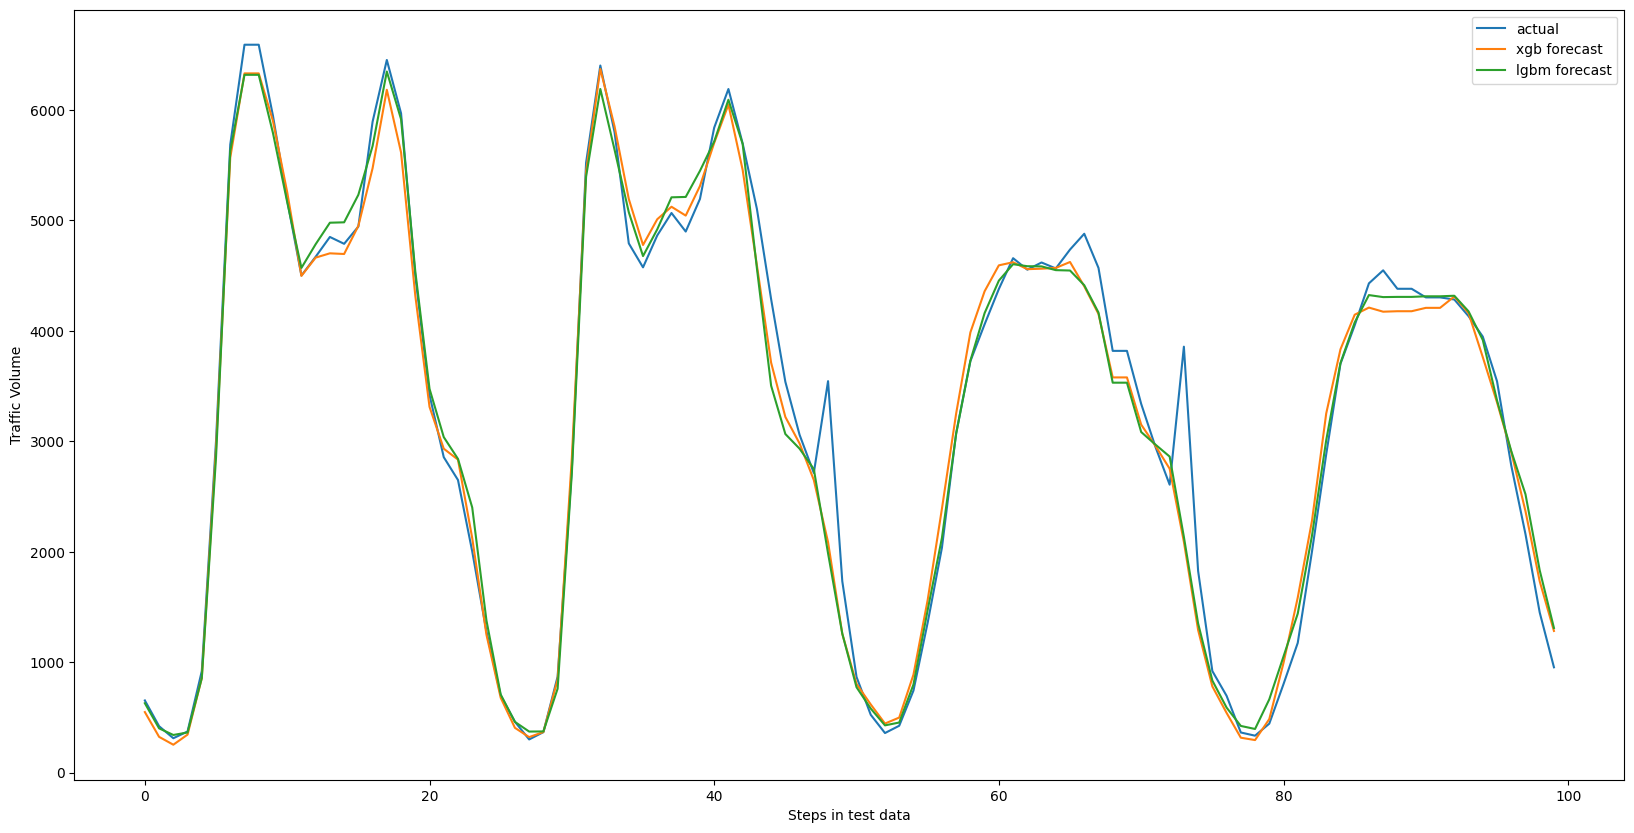

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(list(y_test))
plt.plot(list(xgb_fcst))
plt.plot(list(lgbm_fcst))
plt.legend(['actual', 'xgb forecast', 'lgbm forecast'])
plt.ylabel('Traffic Volume')
plt.xlabel('Steps in test data')
plt.show()


## Listing 15-4. Applying a Bayesian Optimization to the xgboost

In [11]:
pip install scikit-optimize -q

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [15]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import random
random.seed(0)

xgb_opt = BayesSearchCV(
    XGBRegressor(),
    {
        'learning_rate': (10e-6, 1.0, 'log-uniform'),
        'max_depth': Integer(0, 50, 'uniform'),
        'n_estimators' : (10, 1000, 'log-uniform'),
    },
    n_iter=10,
    cv=3
)

xgb_opt.fit(X_train, y_train)
xgb_tuned_fcst = xgb_opt.best_estimator_.predict(X_test)
r2_score(list(y_test), list(xgb_tuned_fcst))


0.9642585341042865

## Listing 15-5. Applying a Bayesian Optimization to the LightGBM

In [16]:
random.seed(0)
lgbm_opt = BayesSearchCV(
    LGBMRegressor(),
    {
        'learning_rate': (10e-6, 1.0, 'log-uniform'),
        'max_depth': Integer(-1, 50, 'uniform'),
        'n_estimators' : (10, 1000, 'log-uniform'),
    },
    n_iter=10,
    cv=3
)

lgbm_opt.fit(X_train, y_train)

lgbm_tuned_fcst = lgbm_opt.best_estimator_.predict(X_test)
r2_score(list(y_test), list(lgbm_tuned_fcst))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 32069, number of used features: 4
[LightGBM] [Info] Start training from score 3257.167888
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set n

0.9679051132233245

## Listing 15-6. Plotting the two tuned models

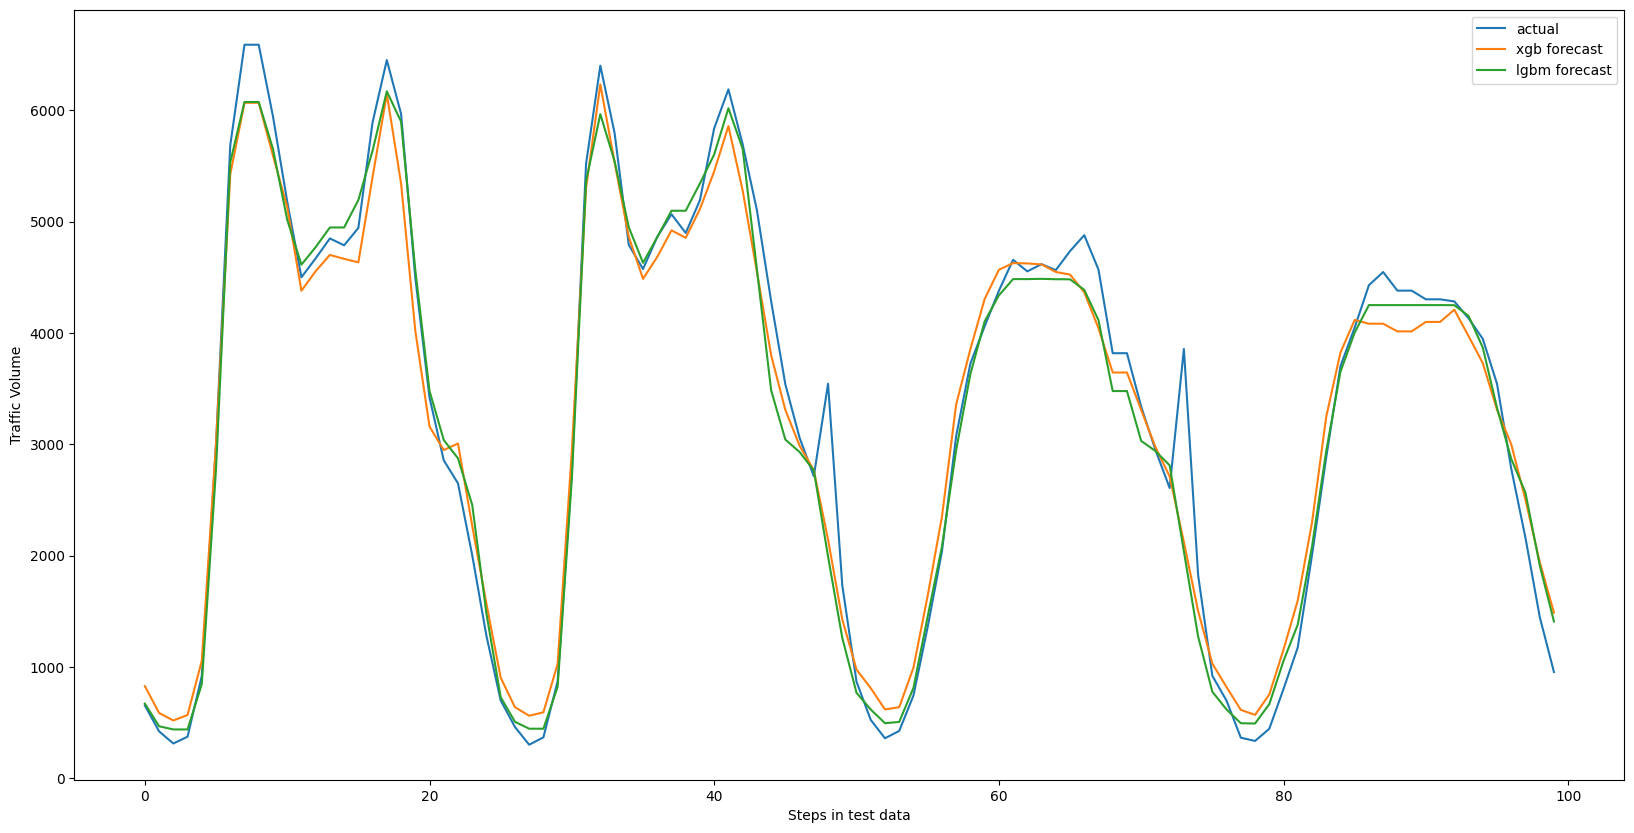

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(list(y_test))
plt.plot(list(xgb_tuned_fcst))
plt.plot(list(lgbm_tuned_fcst))
plt.legend(['actual', 'xgb forecast', 'lgbm forecast'])
plt.ylabel('Traffic Volume')
plt.xlabel('Steps in test data')
plt.show()